1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

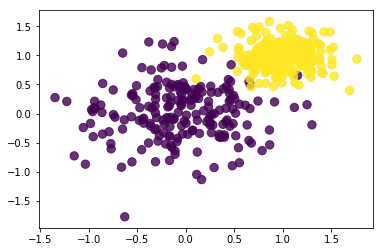

In [1]:
from IPython.display import Image
Image('two_categories_scatter_plot.png')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from scipy.stats import norm

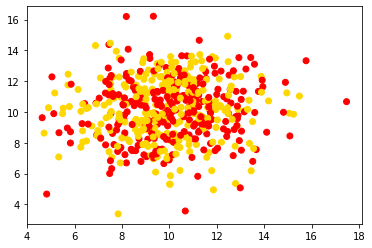

In [28]:
# def generate_2d(mean, std):
# np.random.multivariate_normal(mean, cov, 10000)  
def gauss_2d(mu, sigma, n):
    x, y = [], []
    for i in range(n):
        x.append(random.gauss(mu, sigma))
        y.append(random.gauss(mu, sigma))
        
#     x = random.gauss(mu, sigma)
#     y = random.gauss(mu, sigma)
    return x, y
    return pd.DataFrame(zip(x, y))
x, y = gauss_2d(10, 2, 550)
plt.scatter(x,y, color = ['red', 'gold',]*275 )
    

2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [34]:
import pandas as pd
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
file_name = 'data/residuals_261.pkl'
data = pd.read_pickle(file_name)


--2021-11-30 23:07:17--  https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3uqleyc3wyz52tr/residuals_261.pkl [following]
--2021-11-30 23:07:17--  https://www.dropbox.com/s/raw/3uqleyc3wyz52tr/residuals_261.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9099f3e16036dd164b193d45be.dl.dropboxusercontent.com/cd/0/inline/Ba9c3ajANlL4OD4l0pkfzzOiPVt6SmUTQBzPRe462YdPLaUAjegHjdvPkH2x07XMm0r-TZc54tJbLMhFL4B8nOz2ORExXcnrmsefMIVOIX8byoOvAtn1epU_UsWp5Ejxwm9BDndCWKPj-CKXfcNEgnxn/file# [following]
--2021-11-30 23:07:18--  https://uc9099f3e16036dd164b193d45be.dl.dropboxusercontent.com/cd/0/inline/Ba9c3ajANlL4OD4l0pkfzzOiPVt6SmUTQBzPRe462YdPLaUAjegHjdvPkH2x07XMm0r-TZc5

In [94]:
#absolute values of the variable "residual" smaller than 2
df2 = pd.DataFrame(data.item())
df2

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


(array([382., 618., 590., 570., 446., 444., 498., 414., 422., 441., 449.,
        421., 405., 534., 430., 458., 468., 393., 412., 450., 471., 427.,
        461., 414.,  98.,   8.,   3.,   1.,   2.,   1.]),
 array([ 0.  ,  0.83,  1.66,  2.49,  3.32,  4.15,  4.98,  5.81,  6.64,
         7.47,  8.3 ,  9.13,  9.96, 10.79, 11.62, 12.45, 13.28, 14.11,
        14.94, 15.77, 16.6 , 17.43, 18.26, 19.09, 19.92, 20.75, 21.58,
        22.41, 23.24, 24.07, 24.9 ]),
 <BarContainer object of 30 artists>)

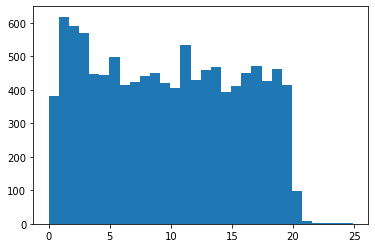

In [44]:
plt.hist(df2["distances"], bins=30)

3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


In [3]:
mu, sigma = 0, 0.1
x0 = np.random.normal(mu, sigma, 100)

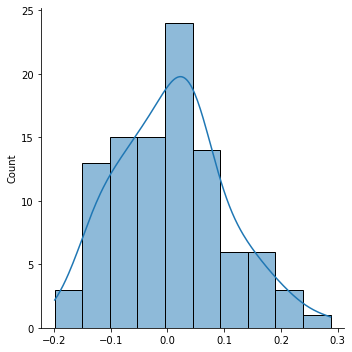

In [4]:
sns.displot(x0, kde=True)

In [49]:
len(x0)

100

In [6]:
rv = norm()
x_gauss = norm.ppf(x0)

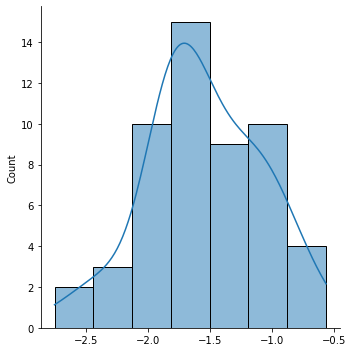

In [7]:
sns.displot(x_gauss, kde=True)